# Imports

In [28]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import librosa
import math

import tensorflow as tf
from tensorflow.keras.models import load_model

# Setting CPU cores

In [14]:
# Tensorflow Configuration
import multiprocessing

# Get the total number of CPU cores available
total_cores = multiprocessing.cpu_count()

# Calculate 75% of available cores (rounded down)
cores_to_use = int(total_cores * 0.90)

# Ensure at least 1 core is used
cores_to_use = max(1, cores_to_use)

# Set the environment variable
os.environ["LOKY_MAX_CPU_COUNT"] = str(cores_to_use)

print(f"Using {cores_to_use} out of {total_cores} available CPU cores (75%)")

# Add after TensorFlow import
tf.config.threading.set_inter_op_parallelism_threads(cores_to_use // 2)
tf.config.threading.set_intra_op_parallelism_threads(cores_to_use // 2)

Using 14 out of 16 available CPU cores (75%)


# Data Settings

In [ ]:
# All bird species available in the HDF5 spectrogram dataset
ALL_BIRD_SPECIES = [
    'amecro',  # American Crow
    'amerob',  # American Robin
    'bewwre',  # Bewick's Wren
    'bkcchi',  # Black-capped Chickadee
    'daejun',  # Dark-eyed Junco
    'houfin',  # House Finch
    'houspa',  # House Sparrow
    'norfli',  # Northern Flicker
    'rewbla',  # Red-winged Blackbird
    'sonspa',  # Song Sparrow
    'spotow',  # Spotted Towhee
    'whcspa',  # White-crowned Sparrow
]

# Relative Paths
DATA_FILE = Path('../data/bird_test_file.hdf5')
MODEL_FILE = "../output/multi-class_results/5_layer_longer_epochs_best_model_results.keras"
RESULT_SAVE_PATH = Path('../output/test_results')

# Audio parameters
sr = 22050
segment_length = 3 * sr
hop_length = segment_length

# Get model & test clips
model = tf.keras.models.load_model(MODEL_FILE)
test_files = sorted(glob.glob("../data/test*.mp3"))

## Test MP3 Prediction Pipeline

Processes audio clips and classifies bird species from the test.mp3s using my pre-trained CNN model.

### 1. **Audio Preprocessing**
- Loads audio clips using `librosa`.
- Segments each audio file into 3-second chunks.
- Pads the final chunk if it's shorter than 3 seconds.

### 2. **Spectrogram Extraction**
- Converts each segment into a Mel-spectrogram (128x517) for input to the model (5-layer longer epoch).
- Uses dB-scaled power spectrograms.

### 3. **Model Inference**
- Passes all spectrograms through the model (5-layer longer epoch).
- Averages the predictions across all segments to get the final probabilities.

### 4. **Visualization**
- Displays bar plots of class probabilities for each segment.
- Saves the plots for inspection.

### 5. **Analysis and Results**
- Extracts top-1 and top-3 predictions.
- Detects if multiple bird species are likely present (>50% confidence in multiple classes).
- Saves predictions to a CSV file and displays the results.

### Output
- Segment prediction plots: `../output/test_results/{file_name}_segments.png`
- Final CSV: `../output/test_results/final_predictions.csv`


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


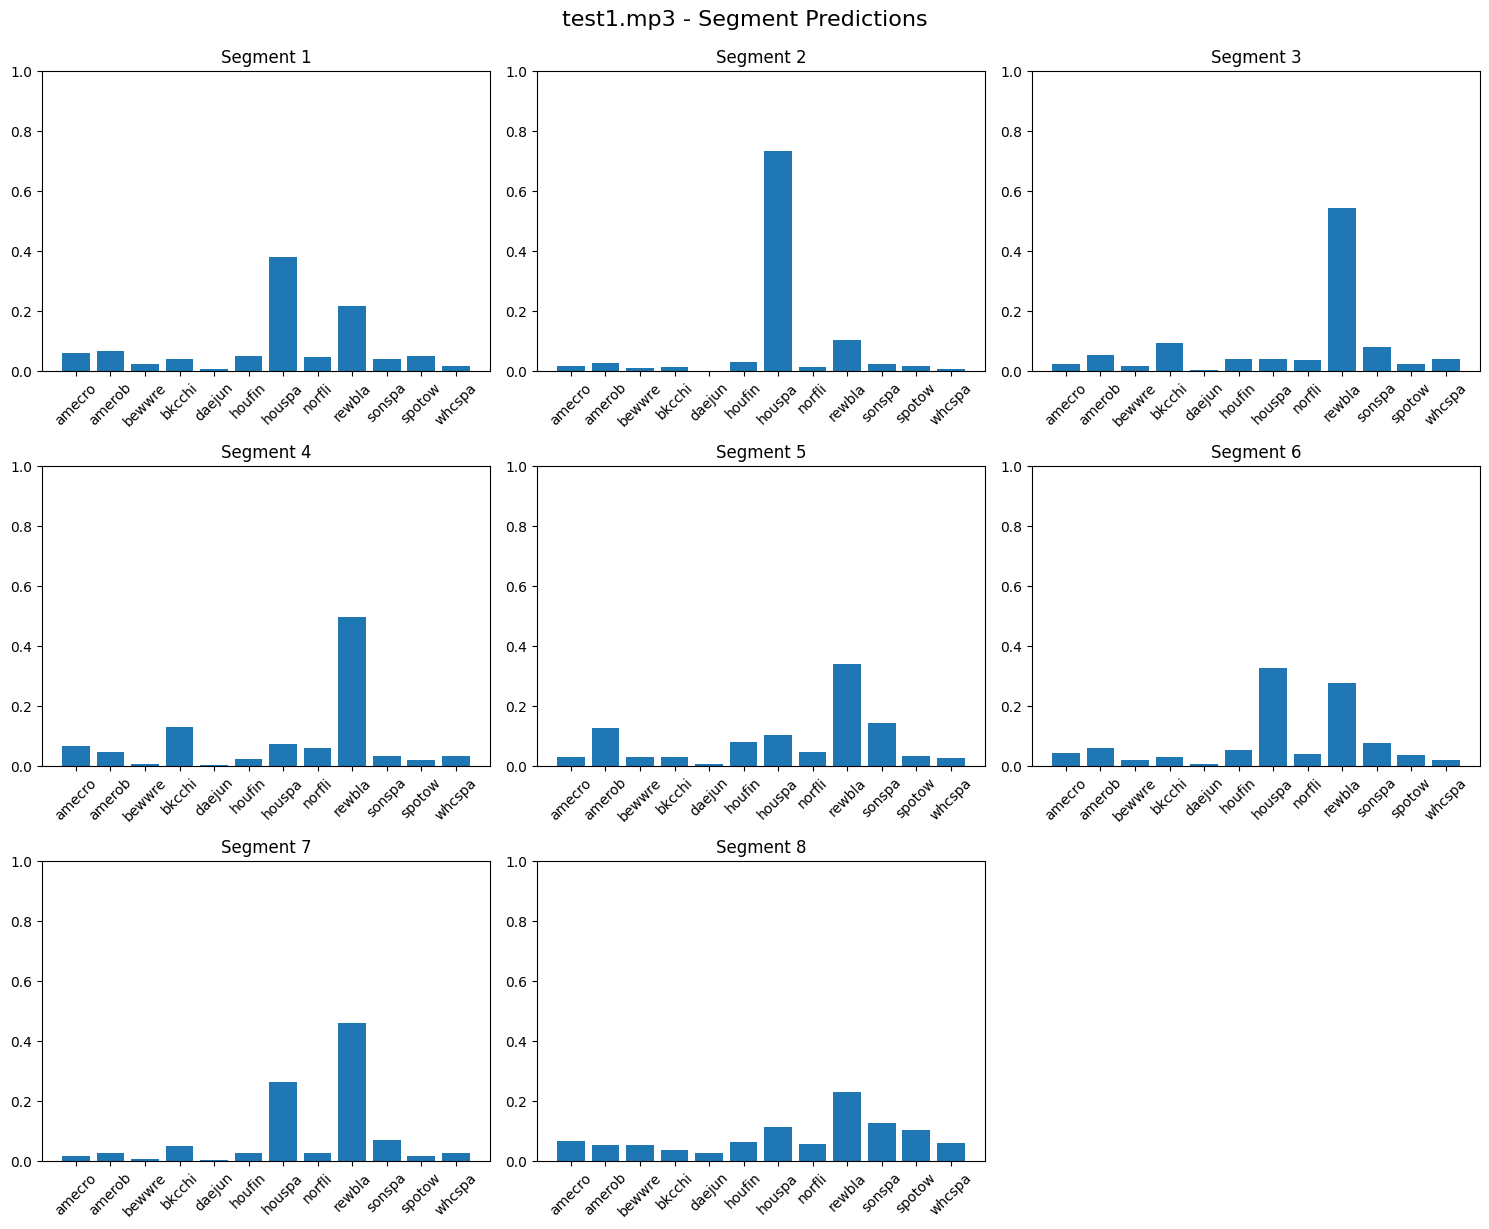

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


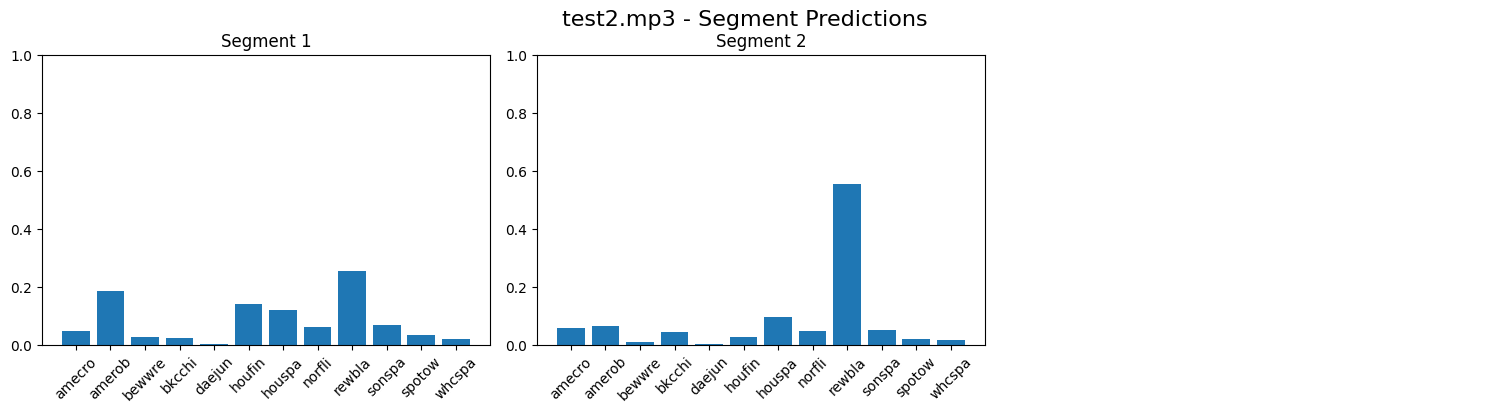

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


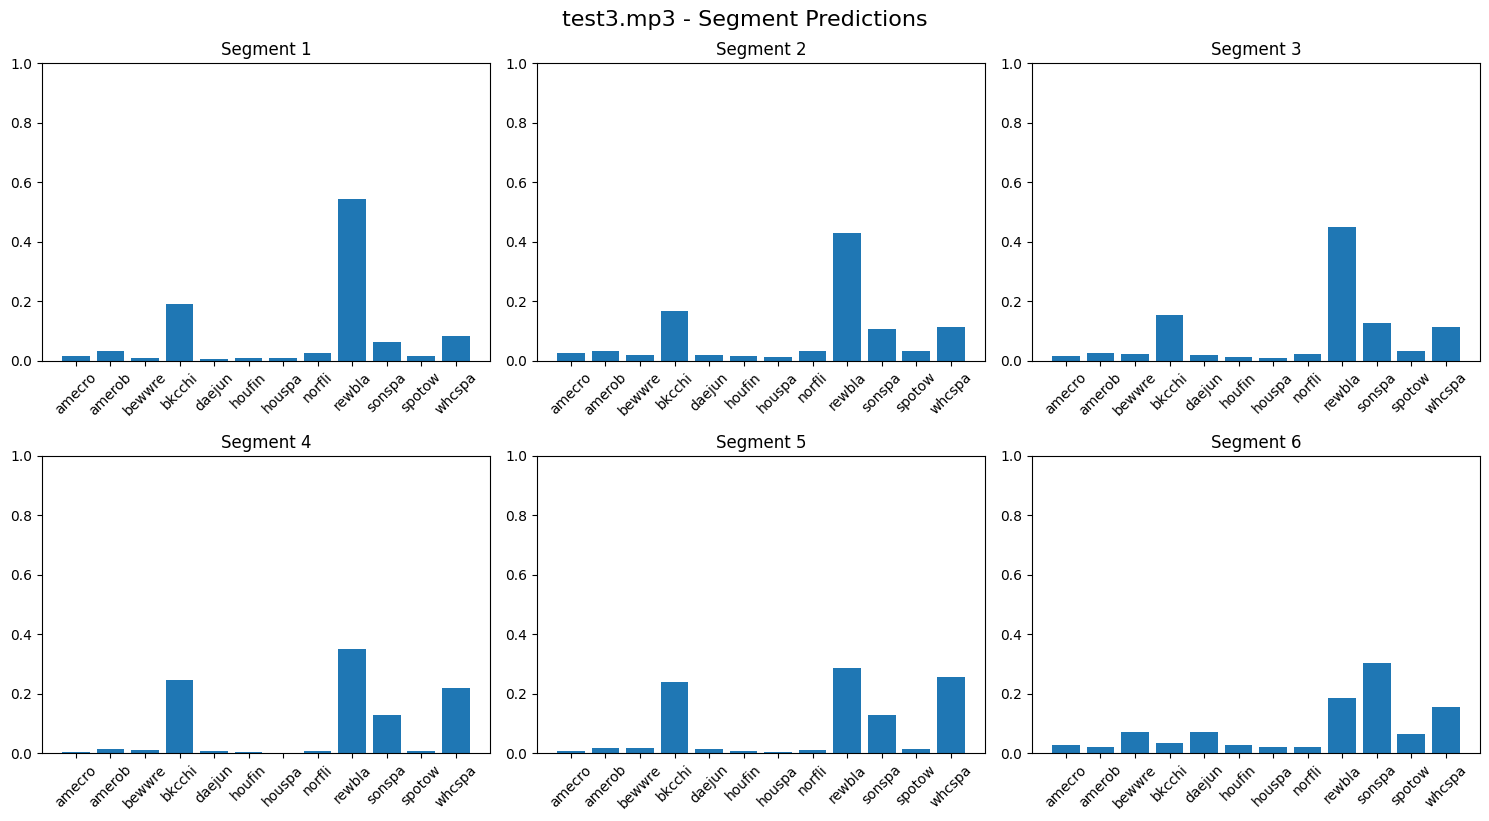


 Final Predictions Summary:
        Clip Top Prediction  Confidence           Top 3 Species Multi-Bird?
0  test1.mp3         rewbla        0.33  rewbla, houspa, sonspa         Yes
1  test2.mp3         rewbla        0.41  rewbla, amerob, houspa          No
2  test3.mp3         rewbla        0.37  rewbla, bkcchi, whcspa          No


In [31]:
final_results = []

# Loop over each audio file
for file_path in test_files:
    file_name = os.path.basename(file_path)  # Extract filename (e.g., test1)

    # Load audio file
    y, _ = librosa.load(file_path, sr=sr)

    # Segment audio into 3-second chunks
    segments = []
    for start in range(0, len(y) - segment_length + 1, hop_length):
        end = start + segment_length
        segments.append(y[start:end])

    # Handle remaining audio by padding
    if len(y) % segment_length != 0:
        remainder = y[len(y) - (len(y) % segment_length):]
        padded_remainder = np.pad(remainder, (0, segment_length - len(remainder)), mode='constant')
        segments.append(padded_remainder)

    # Convert audio segments to mel spectrograms
    X_segments = []
    for segment in segments:
        spec = librosa.feature.melspectrogram(y=segment, sr=sr, hop_length=128, win_length=512)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_db = librosa.util.fix_length(spec_db, size=517, axis=1)
        X_segments.append(spec_db)

    X_segments = np.array(X_segments)[..., np.newaxis]  # Shape: (num_segments, 128, 517, 1)

    # Make predictions on all segments
    probs = model.predict(X_segments)
    avg_probs = np.mean(probs, axis=0)  # Average prediction across all segments

    # Create a 3-column grid of bar plots for segment-wise predictions
    n_segments = len(segments)
    ncols = 3
    nrows = math.ceil(n_segments / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, p in enumerate(probs):
        axes[i].bar(ALL_BIRD_SPECIES, p)
        axes[i].set_title(f"Segment {i+1}")
        axes[i].set_ylim(0, 1)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):  # Hide empty subplots
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"{file_name} - Segment Predictions", y=1.02, fontsize=16)
    plot_path = os.path.join(RESULT_SAVE_PATH, f"{file_name}_segments.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    # Analyze averaged prediction
    top_idx = np.argmax(avg_probs)
    top_label = ALL_BIRD_SPECIES[top_idx]
    top_prob = avg_probs[top_idx]

    # Top 3 predictions
    top3_idx = np.argsort(avg_probs)[-3:][::-1]
    top3_labels = [ALL_BIRD_SPECIES[i] for i in top3_idx]
    top3_probs = [avg_probs[i] for i in top3_idx]

    # Determine if multiple birds are present
    confident_species = set()
    for p in probs:
        for i, prob in enumerate(p):
            if prob > 0.5:
                confident_species.add(i)

    likely_multi = len(confident_species) > 1

    # Save prediction summary for this file
    final_results.append({
        "Clip": file_name,
        "Top Prediction": top_label,
        "Confidence": round(top_prob, 2),
        "Top 3 Species": ", ".join(top3_labels),
        "Multi-Bird?": "Yes" if likely_multi else "No"
    })

# Save and display final summary as CSV and DataFrame
results_df = pd.DataFrame(final_results)
csv_path = os.path.join(RESULT_SAVE_PATH, "final_predictions.csv")
results_df.to_csv(csv_path, index=False)

print("\n Final Predictions Summary:")
print(results_df)